## ENVIROMENT: DEADLY CORIDOR

The purpose of this scenario is to teach the agent to navigate towards his fundamental **goal (the vest)** and make sure he **survives** at the same time.

The map is a corridor with **shooting monsters** on both sides **(6 monsters in total)**. **A green vest** is placed at the opposite end of the corridor. The reward is proportional (negative or positive) to the change in the distance between the player and the vest. If the player ignores monsters on the sides and runs straight for the vest, he will be killed somewhere along the way. To ensure this behavior difficulty level (doom_skill) = 5 (config) is needed.

<img src="./Screenshot 2025-03-06 223447.png"/>

configuration File: `deadly_corridor.cfg`<br>
**DEFAULT REWARD:**
- +dX for getting closer to the vest.
- dX for getting further from the vest.
- -200 for DEATH <br>

**default difficulty level:** `doom_skill` = 5<br>
**AMMO:** 52<br>
**HEALTH:** 100%<br>
**SHILD:** 0<br>

**AVAILABLE MOVES:**
1. actions[0] : MOVE_LEFT`[1 0 0 0 0 0 0]`
2. actions[1] : MOVE_RIGHT`[0 1 0 0 0 0 0]`
3. actions[2] : ATTACK `[0 0 1 0 0 0 0]`
4. actions[3] : MOVE_FORWARD`[0 0 0 1 0 0 0]`
5. actions[4] : MOVE_BACKWARD `[0 0 0 0 1 0 0]`
6. actions[5] : TURN_LEFT `[0 0 0 0 0 1 0]`
7. actions[6] : TURN_RIGHT `[0 0 0 0 0 0 1]`<br>

**RETURNED VARIABLES:**
1. HEALTH
2. HITCOUNT
3. SELECTED_WEAPON_AMMO
4. KILLCOUNT
5. DAMAGE_TAKEN
6. DAMAGECOUNT<br>

In [1]:
from vizdoom import *
import vizdoom as vzd
import random
import time
import numpy as np
import os
import shutil

# SETUP-GAME

In [2]:
game = DoomGame()
game.load_config(r'./scenarios/deadly_corridor.cfg')
game.init()

In [3]:
actions = np.identity(7, dtype=np.uint8)
print(actions)

[[1 0 0 0 0 0 0]
 [0 1 0 0 0 0 0]
 [0 0 1 0 0 0 0]
 [0 0 0 1 0 0 0]
 [0 0 0 0 1 0 0]
 [0 0 0 0 0 1 0]
 [0 0 0 0 0 0 1]]


In [4]:
game.new_episode()
game.is_episode_finished()
game.make_action(random.choice(actions))

0.0

In [5]:
episodes = 3
for e in range(episodes):
    game.new_episode()
    while not game.is_episode_finished():
        satate=game.get_state()
        state = game.get_state()
        img = state.screen_buffer
        # Get the game variables - ammo
        info = state.game_variables
        reward = game.make_action(random.choice(actions),4) # frame skip=4 time for agent to process
        print('reward:', reward) 
        print("ammo",info)
        print("state",state)
        time.sleep(0.02)
    print('////////////////// Result:', game.get_total_reward())
    time.sleep(2)

reward: 0.0
ammo [100.   0.  -1.   0.   0.]
state <vizdoom.vizdoom.GameState object at 0x000002267ECFE530>
reward: 0.0
ammo [100.   0.  52.   0.   0.]
state <vizdoom.vizdoom.GameState object at 0x000002267EC708F0>
reward: 2.9524078369140625
ammo [100.   0.  52.   0.   0.]
state <vizdoom.vizdoom.GameState object at 0x000002266A9162F0>
reward: -9.894577026367188
ammo [64.  0. 52.  0. 36.]
state <vizdoom.vizdoom.GameState object at 0x000002267EB819F0>
reward: -8.983779907226562
ammo [40.  0. 52.  0. 60.]
state <vizdoom.vizdoom.GameState object at 0x000002267EC602B0>
reward: -0.0712127685546875
ammo [40.  0. 52.  0. 60.]
state <vizdoom.vizdoom.GameState object at 0x000002266A9162F0>
reward: 0.8306884765625
ammo [40.  0. 52.  0. 60.]
state <vizdoom.vizdoom.GameState object at 0x000002267EB819F0>
reward: 0.9964752197265625
ammo [40.  0. 52.  0. 60.]
state <vizdoom.vizdoom.GameState object at 0x000002267ECFE570>
reward: 7.7321319580078125
ammo [40.  0. 52.  0. 60.]
state <vizdoom.vizdoom.Game

In [6]:
game.close()

## Converting it to a Gymnasium Environment

In [7]:
import gymnasium as gym
from gymnasium import Env
from gymnasium.spaces import Discrete, Box
import cv2
import torch
import torch.nn as nn
import torch.nn.functional as F
from stable_baselines3 import DQN, PPO
from stable_baselines3.common import env_checker
from stable_baselines3.common.callbacks import BaseCallback
from stable_baselines3.common.evaluation import evaluate_policy
from stable_baselines3.common.monitor import Monitor
from stable_baselines3.common.torch_layers import BaseFeaturesExtractor
from stable_baselines3.common.env_util import make_vec_env
from matplotlib import pyplot as plt
import torchvision
import torchaudio
from stable_baselines3.common.callbacks import CheckpointCallback

In [9]:
game = DoomGame()
game.load_config(r'./scenarios/deadly_corridor.cfg')
game.init()

In [9]:
game.get_state().screen_buffer

array([[[ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        ...,
        [19, 19, 11, ..., 47, 47, 55],
        [19, 27, 19, ..., 47, 47, 47],
        [11, 19, 19, ..., 27, 19, 19]],

       [[ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        [ 0,  0,  0, ...,  0,  0,  0],
        ...,
        [19, 19, 11, ..., 47, 47, 55],
        [19, 27, 19, ..., 47, 47, 47],
        [11, 19, 19, ..., 27, 19, 19]],

       [[23, 35, 11, ..., 23, 35, 11],
        [23, 11, 35, ..., 11, 35, 35],
        [35, 35, 35, ..., 11, 35, 11],
        ...,
        [19, 19, 11, ..., 47, 47, 55],
        [19, 27, 19, ..., 47, 47, 47],
        [11, 19, 19, ..., 27, 19, 19]]], dtype=uint8)

In [9]:
class VizDoomGym(Env):
    def __init__(self, render=False,config='./scenarios/deadly_corridor-skill-1.cfg'):
        super().__init__()
        self.game = vzd.DoomGame()
        self.game.load_config(config)

        # Render frame logic
        if not render:
            self.game.set_window_visible(False)
        else:
            self.game.set_window_visible(True)
        self.game.init()

        # Create the action space and observation space
        self.observation_space = Box(low=0, high=255, shape=(100, 160, 1), dtype=np.uint8)
        self.action_space = Discrete(7)  # 7 possible actions
        self.actions=np.identity(7, dtype=np.float32)
        


    def custom_reward(self, prev_state, current_state):
        reward = 0
    
        # Extract game variables
        prev_health = prev_state.game_variables[0]  # HEALTH
        prev_hits = prev_state.game_variables[1]  # HITCOUNT
        prev_ammo = prev_state.game_variables[2]  # SELECTED_WEAPON_AMMO
        prev_kills = prev_state.game_variables[3]  # KILLCOUNT
        prev_dmg = prev_state.game_variables[4]  # damage_taken
        prev_dmg_deal = prev_state.game_variables[5]  # damage_dealed
        
        current_health = current_state.game_variables[0]  # HEALTH
        current_hits = current_state.game_variables[1]  # HITCOUNT
        current_ammo = current_state.game_variables[2]  # SELECTED_WEAPON_AMMO
        current_kills = current_state.game_variables[3]  # KILLCOUNT
        current_dmg = current_state.game_variables[4]  # damage_taken
        current_dmg_deal = current_state.game_variables[5]  # damage_dealed
        
        ammo_delta=current_ammo-prev_ammo 
        hitcount_delta= current_dmg_deal - prev_dmg_deal
        damage_taken_delta=-current_dmg+prev_dmg
        
        reward = damage_taken_delta*50 + hitcount_delta*200  + ammo_delta*40 
        
    

        return reward
        
    def step(self, action):
        prev_state = self.game.get_state()  # Store the previous state
        reward = self.game.make_action(self.actions[action], 4)  # Default reward
        current_state = self.game.get_state()  # Get the current state

        # Compute custom reward
        if prev_state is not None and current_state is not None:
            reward += self.custom_reward(prev_state, current_state)

        terminated = self.game.is_episode_finished()
        truncated = self.game.get_episode_time() >= self.game.get_episode_timeout()

        state = np.zeros(self.observation_space.shape, dtype=np.uint8)  # Default blank state
        info = {"ammo": 0}  # Default info

        if not (terminated or truncated):
            game_state = self.game.get_state()
            if game_state is not None:
                state = self.grayscale(game_state.screen_buffer)
                info = {"ammo": game_state.game_variables[0]}

        return state, reward, terminated, truncated, info

    def reset(self, seed=None, options=None):
        """Restart the game and return the initial state."""
        self.game.new_episode()
        state = self.game.get_state().screen_buffer
        return self.grayscale(state), {}

    def grayscale(self, observation):
        """Convert the observation to grayscale and resize it."""
        gray = cv2.cvtColor(np.moveaxis(observation, 0, -1), cv2.COLOR_BGR2GRAY)
        resize = cv2.resize(gray, (160, 100), interpolation=cv2.INTER_CUBIC)
        state = np.reshape(resize, (100, 160, 1))
        return state

    def close(self):
        """Close the game."""
        self.game.close()

### REWARD FUNCTION EXPLAINED
<u> **IN STEP FUNCTION:** </u><br>
**prev_state = self.game.get_state()** *Store the previous state*<br>
**reward = self.game.make_action(self.actions[action], 4)** *DEFAULT REWARD: -200 FOR DEATH -dx for going back +dx for going forward*<br>
**current_state = self.game.get_state()** *Get the current state*<br>
<br>
<i style="color:red"> the `prev_state` and `current_state` values are sent to the `custom_reward` fucntion which return a reward added to the default one </i><br>
<u> **IN custom_reward FUNCTION:** </u><br>
1. current_health = current_state.game_variables[0]  # HEALTH
2. current_hits = current_state.game_variables[1]  # HITCOUNT
3. current_ammo = current_state.game_variables[2]  # SELECTED_WEAPON_AMMO
4. current_kills = current_state.game_variables[3]  # KILLCOUNT
5. current_dmg = current_state.game_variables[4]  # damage_taken
6. current_dmg_deal = current_state.game_variables[5]  # damage_dealed

<br>**we calculate deltas** :<br>
1. ammo_delta=current_ammo-prev_ammo
2. hitcount_delta= current_dmg_deal - prev_dmg_deal
3. damage_taken_delta=-current_dmg+prev_dmg<br>

<b style="color:red">REWARD:<BR>
`reward = damage_taken_delta*50 + hitcount_delta*200  + ammo_delta*40`
</b>

<h4 style="color: red">CURRICULUM LEARNING approach</h4><br>

**IN ORDER TO GET THE AGENT TO BE ABLE TO PLAY THE VIZDOOM GAME WITH `DIFFICULTY LEVEL:` *5* WE STARTED TRAINING THE AGENT ON THE `DIFFICULTY LEVEL` *1* AND WE WENT UP ON LEVEL FOR THIS PURPOSE WE CREATED 5 ENVIROMENT:** <BR>
1. `deadly_corridor-skill-1.cfg` FOR `SKILL LEVEL 1`.
2. `deadly_corridor-skill-2.cfg` FOR `SKILL LEVEL 2`.
3. `deadly_corridor-skill-3.cfg` FOR `SKILL LEVEL 3`.
4. `deadly_corridor-skill-4.cfg` FOR `SKILL LEVEL 4`.
5. `deadly_corridor-skill-5.cfg` FOR `SKILL LEVEL 5`.


In [5]:
env = VizDoomGym(render=True)
state,_ = env.reset()
print(state)

[[[32]
  [33]
  [25]
  ...
  [27]
  [23]
  [24]]

 [[27]
  [33]
  [23]
  ...
  [24]
  [24]
  [24]]

 [[20]
  [35]
  [23]
  ...
  [24]
  [24]
  [24]]

 ...

 [[75]
  [63]
  [62]
  ...
  [44]
  [71]
  [60]]

 [[15]
  [48]
  [47]
  ...
  [49]
  [69]
  [47]]

 [[22]
  [14]
  [26]
  ...
  [57]
  [37]
  [39]]]


In [10]:
game.close()

In [85]:
env.reset()

(array([[[32],
         [33],
         [25],
         ...,
         [27],
         [23],
         [24]],
 
        [[27],
         [33],
         [23],
         ...,
         [24],
         [24],
         [24]],
 
        [[20],
         [35],
         [23],
         ...,
         [24],
         [24],
         [24]],
 
        ...,
 
        [[75],
         [63],
         [62],
         ...,
         [44],
         [71],
         [60]],
 
        [[15],
         [48],
         [47],
         ...,
         [49],
         [69],
         [47]],
 
        [[22],
         [14],
         [26],
         ...,
         [57],
         [37],
         [39]]], dtype=uint8),
 {})

In [86]:
env_checker.check_env(env)

In [87]:
env.close()

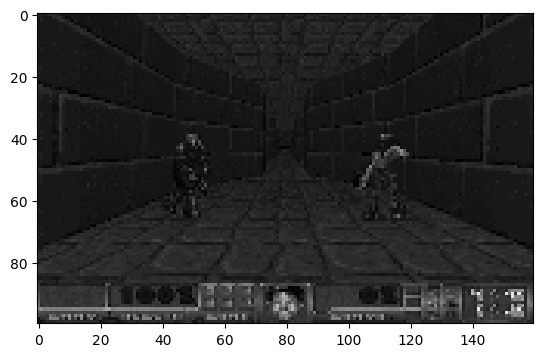

In [74]:
plt.imshow(cv2.cvtColor(state, cv2.COLOR_BGR2RGB))

### this is the grayscale image

In [5]:
class TrainAndLoggingCallback(BaseCallback):

    def __init__(self, check_freq, save_path, verbose=1):
        super(TrainAndLoggingCallback, self).__init__(verbose)
        self.check_freq = check_freq
        self.save_path = save_path

    def _init_callback(self):
        if self.save_path is not None:
            os.makedirs(self.save_path, exist_ok=True)

    def _on_step(self):
        if self.n_calls % self.check_freq == 0:
            model_path = os.path.join(self.save_path, 'best_model_{}'.format(self.n_calls))
            self.model.save(model_path)

        return True


In [5]:
CHECKPOINT_DIR = './train/train_Deadly_Corridor'
LOG_DIR = './logs/log_Deadly_Corridor'

In [6]:
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

In [7]:
env=VizDoomGym()

In [8]:
model = PPO('CnnPolicy', env, tensorboard_log=LOG_DIR, verbose=1, learning_rate=0.00001, n_steps=8192, clip_range=.1, gamma=.95, gae_lambda=.9)

Using cuda device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


## Training phase 1
`200000 steps`<br>
**LOG: PPO_7**

In [11]:
model.learn(total_timesteps=200000, callback=callback)
env.close()

Logging to ./logs/log_Deadly_Corridor\PPO_7
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 255      |
|    ep_rew_mean     | 1.67e+03 |
| time/              |          |
|    fps             | 12       |
|    iterations      | 1        |
|    time_elapsed    | 634      |
|    total_timesteps | 8192     |
---------------------------------
------------------------------------------
| rollout/                |              |
|    ep_len_mean          | 238          |
|    ep_rew_mean          | 1.71e+03     |
| time/                   |              |
|    fps                  | 12           |
|    iterations           | 2            |
|    time_elapsed         | 1355         |
|    total_timesteps      | 16384        |
| train/                  |              |
|    approx_kl            | 0.0033908342 |
|    clip_fraction        | 0.213        |
|    clip_range           | 0.1          |
|    entropy_loss         | -1.94        |
|    explained

### Testing

In [97]:
model=PPO.load("./train/train_deadly_corridor/best_model_90000")

In [98]:
env=VizDoomGym(render=True)

In [101]:
import torch
import numpy as np
from stable_baselines3 import DQN, PPO 
import cv2


model_path = "./train/train_deadly_corridor/best_model_90000.zip"  
model = PPO.load(model_path)


env = VizDoomGym(render=True)  
num_episodes = 4


for episode in range(num_episodes):
    obs,_ = env.reset()
    done = False
    total_reward = 0
    while not done: 
        action, _ = model.predict(obs)
        obs, reward, terminated, truncated, info = env.step(action)
        time.sleep(0.10)
        total_reward += reward
        done=terminated or truncated
        # time.sleep(1)
    print(f"Episode {episode + 1}: Total Reward = {total_reward}")
    time.sleep(2)
  
# Close environment
env.close()


Episode 1: Total Reward = 2389.7539672851562
Episode 2: Total Reward = 1955.1833953857422
Episode 3: Total Reward = 3634.187210083008
Episode 4: Total Reward = 2469.2147827148438


## The model is not learning to go further in the dangeon and is losing amo so we will increase penalty on amo and hitcount

In [11]:
model_path = "./train/train_deadly_corridor/best_model_230000.zip"  
model = PPO.load(model_path)


## Training phase 2
`10000 steps`<br>
**LOG: PPO_8**

## RETRAINING

In [15]:
env=VizDoomGym()
CHECKPOINT_DIR = './train/train_Deadly_Corridor_COMP'
LOG_DIR = './logs/log_Deadly_Corridor'
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

In [16]:
model.set_env(env)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [17]:
model.learn(total_timesteps=100000, callback=callback)

Logging to ./logs/log_Deadly_Corridor\PPO_8
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 259      |
|    ep_rew_mean     | 1.61e+03 |
| time/              |          |
|    fps             | 12       |
|    iterations      | 1        |
|    time_elapsed    | 635      |
|    total_timesteps | 8192     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 277         |
|    ep_rew_mean          | 2.31e+03    |
| time/                   |             |
|    fps                  | 12          |
|    iterations           | 2           |
|    time_elapsed         | 1344        |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.004817075 |
|    clip_fraction        | 0.313       |
|    clip_range           | 0.1         |
|    entropy_loss         | -1.73       |
|    explained_variance   | 

**PPO 4 7 8** 

#### Testing again `./train/train_Deadly_Corridor_COMP/best_model_100000.zip`

In [6]:
import torch
import numpy as np
from stable_baselines3 import DQN, PPO 
import cv2


model_path = "./train/train_Deadly_Corridor_COMP/best_model_100000.zip"  
model = PPO.load(model_path)


env = VizDoomGym(render=True)  
num_episodes = 4


for episode in range(num_episodes):
    obs,_ = env.reset()
    done = False
    total_reward = 0
    while not done: 
        action, _ = model.predict(obs)
        obs, reward, terminated, truncated, info = env.step(action)
        time.sleep(0.10)
        total_reward += reward
        done=terminated or truncated
        # time.sleep(1)
    print(f"Episode {episode + 1}: Total Reward = {total_reward}")
    time.sleep(2)
  
# Close environment
env.close()


Episode 1: Total Reward = 80.13021850585938
Episode 2: Total Reward = 7222.541305541992
Episode 3: Total Reward = 8597.309310913086
Episode 4: Total Reward = 13160.359771728516


### The agent need more training 
`from 4 trails it hits the goal one time`

In [5]:
model_path = "./train/train_deadly_corridor/best_model_230000.zip"  
model = PPO.load(model_path)


## Training phase 3
`10000 steps`<br>
**LOG: PPO_9**

In [6]:
env=VizDoomGym()
CHECKPOINT_DIR = './train/train_Deadly_Corridor_COMP_2'
LOG_DIR = './logs/log_Deadly_Corridor'
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

In [7]:
model.set_env(env)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [8]:
model.learn(total_timesteps=100000, callback=callback)

Logging to ./logs/log_Deadly_Corridor\PPO_9
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 264      |
|    ep_rew_mean     | 2.65e+03 |
| time/              |          |
|    fps             | 13       |
|    iterations      | 1        |
|    time_elapsed    | 625      |
|    total_timesteps | 8192     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 257         |
|    ep_rew_mean          | 2.68e+03    |
| time/                   |             |
|    fps                  | 12          |
|    iterations           | 2           |
|    time_elapsed         | 1346        |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.006551397 |
|    clip_fraction        | 0.303       |
|    clip_range           | 0.1         |
|    entropy_loss         | -1.72       |
|    explained_variance   | 

**Testing The new model:** `./train/train_Deadly_Corridor_COMP_2/best_model_90000.zip`

In [9]:
import torch
import numpy as np
from stable_baselines3 import DQN, PPO 
import cv2


model_path = "./train/train_Deadly_Corridor_COMP_2/best_model_90000.zip"  
model = PPO.load(model_path)


env = VizDoomGym(render=True)  
num_episodes = 4


for episode in range(num_episodes):
    obs,_ = env.reset()
    done = False
    total_reward = 0
    while not done: 
        action, _ = model.predict(obs)
        obs, reward, terminated, truncated, info = env.step(action)
        time.sleep(0.10)
        total_reward += reward
        done=terminated or truncated
        # time.sleep(1)
    print(f"Episode {episode + 1}: Total Reward = {total_reward}")
    time.sleep(2)
  
# Close environment
env.close()


Episode 1: Total Reward = 13140.322280883789
Episode 2: Total Reward = 2121.351348876953
Episode 3: Total Reward = 5939.368347167969
Episode 4: Total Reward = 4392.720138549805


## Training phase 4
`100000 steps`<br>
**LOG: PPO_10**<br>
<b style="color:red">NEW REWARD</b>

**The agent is losing too much amo, but overall it's better** <br>
**changing the reward system and retraining**<br>
*old:*<br>
`reward = damage_taken_delta*40 + hitcount_delta*200  + ammo_delta*20 `<br>
*new:*<br>
`reward = damage_taken_delta*50 + hitcount_delta*200  + ammo_delta*40`

In [12]:
model_path = "./train/train_Deadly_Corridor_COMP_2/best_model_90000.zip"  
model = PPO.load(model_path)

In [13]:
env=VizDoomGym()
CHECKPOINT_DIR = './train/train_Deadly_Corridor_COMP_3'
LOG_DIR = './logs/log_Deadly_Corridor'
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

In [14]:
model.set_env(env)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [15]:
model.learn(total_timesteps=100000, callback=callback)

Logging to ./logs/log_Deadly_Corridor\PPO_10
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 290      |
|    ep_rew_mean     | 5.53e+03 |
| time/              |          |
|    fps             | 12       |
|    iterations      | 1        |
|    time_elapsed    | 631      |
|    total_timesteps | 8192     |
---------------------------------
----------------------------------------
| rollout/                |            |
|    ep_len_mean          | 275        |
|    ep_rew_mean          | 5.49e+03   |
| time/                   |            |
|    fps                  | 12         |
|    iterations           | 2          |
|    time_elapsed         | 1279       |
|    total_timesteps      | 16384      |
| train/                  |            |
|    approx_kl            | 0.00971652 |
|    clip_fraction        | 0.363      |
|    clip_range           | 0.1        |
|    entropy_loss         | -1.66      |
|    explained_variance   | 0.396      |


**Testing The new model:** `./train/train_Deadly_Corridor_COMP_3/best_model_90000.zip`

In [16]:
import torch
import numpy as np
from stable_baselines3 import DQN, PPO 
import cv2


model_path = "./train/train_Deadly_Corridor_COMP_3/best_model_90000.zip"  
model = PPO.load(model_path)


env = VizDoomGym(render=True)  
num_episodes = 4


for episode in range(num_episodes):
    obs,_ = env.reset()
    done = False
    total_reward = 0
    while not done: 
        action, _ = model.predict(obs)
        obs, reward, terminated, truncated, info = env.step(action)
        time.sleep(0.10)
        total_reward += reward
        done=terminated or truncated
        # time.sleep(1)
    print(f"Episode {episode + 1}: Total Reward = {total_reward}")
    time.sleep(2)
  
# Close environment
env.close()


Episode 1: Total Reward = 15657.062576293945
Episode 2: Total Reward = 6334.014587402344
Episode 3: Total Reward = 9659.362380981445
Episode 4: Total Reward = 1125.349624633789


**The agent need more training**
`from 4 trails it hits the goal 3 times`

## Training phase 5
`10000 steps`<br>
**LOG: PPO_11**

In [17]:
model_path = "./train/train_Deadly_Corridor_COMP_3/best_model_90000.zip"  
model = PPO.load(model_path)

In [18]:
env=VizDoomGym()
CHECKPOINT_DIR = './train/train_Deadly_Corridor_COMP_4'
LOG_DIR = './logs/log_Deadly_Corridor'
callback = TrainAndLoggingCallback(check_freq=10000, save_path=CHECKPOINT_DIR)

In [19]:
model.set_env(env)

Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
Wrapping the env in a VecTransposeImage.


In [20]:
model.learn(total_timesteps=100000, callback=callback)

Logging to ./logs/log_Deadly_Corridor\PPO_11
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 292      |
|    ep_rew_mean     | 9.61e+03 |
| time/              |          |
|    fps             | 12       |
|    iterations      | 1        |
|    time_elapsed    | 655      |
|    total_timesteps | 8192     |
---------------------------------
-----------------------------------------
| rollout/                |             |
|    ep_len_mean          | 314         |
|    ep_rew_mean          | 9.6e+03     |
| time/                   |             |
|    fps                  | 11          |
|    iterations           | 2           |
|    time_elapsed         | 1379        |
|    total_timesteps      | 16384       |
| train/                  |             |
|    approx_kl            | 0.011990368 |
|    clip_fraction        | 0.429       |
|    clip_range           | 0.1         |
|    entropy_loss         | -1.46       |
|    explained_variance   |

## Testing

In [21]:
import torch
import numpy as np
from stable_baselines3 import DQN, PPO 
import cv2


model_path = "./train/train_Deadly_Corridor_COMP_4/best_model_90000.zip"  
model = PPO.load(model_path)


env = VizDoomGym(render=True)  
num_episodes = 4


for episode in range(num_episodes):
    obs,_ = env.reset()
    done = False
    total_reward = 0
    while not done: 
        action, _ = model.predict(obs)
        obs, reward, terminated, truncated, info = env.step(action)
        time.sleep(0.10)
        total_reward += reward
        done=terminated or truncated
        # time.sleep(1)
    print(f"Episode {episode + 1}: Total Reward = {total_reward}")
    time.sleep(2)
  
# Close environment
env.close()


Episode 1: Total Reward = 17079.532836914062
Episode 2: Total Reward = 11199.851608276367
Episode 3: Total Reward = 12779.037246704102
Episode 4: Total Reward = 7574.6090087890625


**the agent is not killing the last enemy sometimes**

In [22]:
import torch
import numpy as np
from stable_baselines3 import DQN, PPO 
import cv2


model_path = "./train/train_Deadly_Corridor_COMP_4/best_model_70000.zip"  
model = PPO.load(model_path)


env = VizDoomGym(render=True)  
num_episodes = 4


for episode in range(num_episodes):
    obs,_ = env.reset()
    done = False
    total_reward = 0
    while not done: 
        action, _ = model.predict(obs)
        obs, reward, terminated, truncated, info = env.step(action)
        time.sleep(0.10)
        total_reward += reward
        done=terminated or truncated
        # time.sleep(1)
    print(f"Episode {episode + 1}: Total Reward = {total_reward}")
    time.sleep(2)
  
# Close environment
env.close()


Episode 1: Total Reward = 4210.972625732422
Episode 2: Total Reward = 11697.345169067383
Episode 3: Total Reward = 14136.524642944336
Episode 4: Total Reward = 6652.1153564453125


### WE CHOOSE THIS MODEL DUE TO THE OBSERVATION OF `EP_REW_MEAN` AND `EP_LEN_MEAN`
<img src="./Screenshot 2025-03-06 231351.png"/>
<img src="./Screenshot 2025-03-06 231409.png"/>


**The model `./train/train_Deadly_Corridor_COMP_4/best_model_80000.zip` is the gest**